# Problem Specification

![lenna face](./images/frex.png)

The problem we would like to address for this notebook is the face recognition problem. In this problem, we are given an input image as seen below, and we would like to determine the identity of the person given a database of currently known people and images that are known to contain their faces. At first sight, we might be tempted to jump into a deep learning model and simply place the images into the network as seen above. However, there is a critical issue with doing such a thing. While the batches seen above do seem to be centered about the face, what happens if we give it an image where the face is located on a corner and is much smaller?
$$$$
As it turns out, there are actually many ways to approach this problem, but there is some consistent notion of a pipeline that is maintained for this type of problem. The pipeline consists of the following steps:
    - Face Detection
    - Face Alignment
    - Feature Extraction
    - Classification / Similarity Calculation / Clustering

The fact that we can describe the problem with such a pipeline would generally mean that we could implement each of these parts and create a somewhat decent pipeline. However, as methods have gotten more complex, a lot of these steps seem to have begun to converge into attempts to create some end-to-end pipeline. There are actually networks that allow for a single forward pass evaluation, but as training is still not performed via the end-to-end pipeline, we could call these methods fake end-to-end pipelines. Putting that aside, I will explain the sub-problems with a couple sentences and describe to most typical ways to implement them.

#### Face Detection
![lenna face](./images/lenna.png)
The purpose of this subproblem is to localize faces within an image. By localizing these faces, the future steps will have a much easier time dealing with the problem as the remaining problems' computational complexity scales quite heavily with the amount of suggested faces made by the face detection portion. With that being said, there is actually no requirement for this face detection step to return _only_ valid regions. By the very nature of this portion of the network acting as a region proposal network, or RPN, the only requirement is that the output __potentially__ contain the relevant parts of the image. Any number of detections is fine so long as it eliminates the need to run a sliding window over the input image and make random guesses for the location of the face. Note that not performing this step efficiently (isolating the __actual__ bounding boxes of the face) may actually lead to the curse of dimensionality having some effect on the overall pipeline.
$$$$
The typical way to implement a face detection algorithm is either through some deep RPN (R-CNN) or boosting region proposal method as they tend to localize faces very quickly. This is often the bottleneck of the execution pipeline, and YOLO was able to optimize this portion enough to achieve near real-time performance on their detection problem.

#### Face Alignment
<img src="./images/align.png" alt="landmarks" style="height: 300px;"/>

In this step, we have detected some faces and extracted them from the original image. This step is actually optional, but it is extremely helpful depending on the input dataset for a couple reasons. These reasons follow now:
    1. The number of poses a face can be in can be extremely large
    2. Faces are not guaranteed to follow the orientations present in the dataset
    3. Expanding the dataset is sometimes prohibitively expensive due to the number of potential classes
It is for these reasons that alignment is often performed before the following steps. By aligning the face in the front-facing orientation, it lessens the chances of a pose not being present in the original dataset distribution and thus increases the chances of a proper classification.
$$$$
The typical method for this subproblem is an inverse matrix problem calculated through the use of anchor points that identify common facial landmarks. 3D alignment is still a bit unstable due to the intermediate step of creating a model for use in the warping, but it is still an area with much work being performed.

#### Feature Extraction
<img src="./images/feats.png" alt="feats" style="height: 200px;"/>

In this step, we have obtained an aligned or unaligned face that must be reduced to a dimension where the classification / clustering task can be performed much more quickly. We have actually covered a perfectly good feature extractor: the typical CNN! This subproblem is more often performed in conjunction with the classification as it allows for the error rate to be reduced through the automatic selection of relevant features, but handpicking features is not an entirely unrealistic thing to do. A common way to handpick features would be to train an unsupervised network for the purpose of encoding the features into some lower dimensional latent space (through thresholded PCA or some deep autoencoder).

#### Classification / Similarity Calculation / Clustering
<img src="./images/tsne.png" alt="tsne" style="height: 300px;"/>

This final part of the network is the only part of the network performing the task at hand. Classification and/or similarity calculations are performed through supervised techniques such as the latter half of the CNN, decision trees, or support vector machines. Clustering is performed through unsupervised tasks such as KNN or graph based methods (ie. graph convolutional networks). Any typical supervised/unsupervised algorithm that works with images could be a potential candidate for this part of the task.

### Discussion
Why do you believe that this pipeline has been designed as such? Are there any concerns that may come about from adhering to this pipeline too strongly? Are these steps completely exclusive from one another or is there room for overlap in these steps?

# Implementation
Our implementation will apply two different algorithms and ignore the explicit face alignment for simplicity. The algorithm for alignment often follows a GAN approach or landmark mapping approach, both of which cannot be covered right now due to how much extra information would be needed to properly implement and understand them. Instead, we will be looking at two different face detection techniques and evaluate using a simple VGG classification. This classification part will also be varied by using a different optimization metric in both scenarios. First, we will evaluate on a softmax, which only emphasizes raw probabilistic values. Afterward, we will evaluate the network on a triplet loss, which is designed to emphasize separation between classes. There are a couple differences that come about as a result of each optimization that we will analyze. Finally, we will consider the usefulness of our choices and consider which would be the best to implement under certain scenarios.
$$$$
Because we just want to have a somewhat familar scenario for face recognition, we will deal with the subportion of the CelebA dataset. The CelebA dataset is useful for many tasks as it provides individually picked features (ie. eye color, hair color, etc.), along with familar structures such as detected facial landmarks, ids, and segmented facial maps. In our scenario, we will only be using the id's in order to test out our face recognition pipeline along the way.

## Face Detection
### Haar Cascade Face Detection (Not Deep Detection)
![frcasc](./images/pyramid.jpg)
In this section, we will be using OpenCV in order to implement a basic face detection method. Haar cascade detection networks are quite easy to implement and function very much like a classification network that returns the regions for which the classifier has indicated a positive output. As a simple explanation of how this particular algorithm works, evaluation is performed by considering a sliding window over a series of images which are subsampled to reduce their size (this is effectively called an image pyramid as seen above) . Effectively, this is performing a face check on every single possible sliding window over the image. This is obviously ineffective once you realize that a typical cascade network contains about 100 weak classifiers. As a result, classification is actually performed in a series of stages, each of which rule out a significant number of proposed regions depending on the weak classifier in question. This way, by the time most of the weak classifiers are being applied, the number of possible frames has been significantly reduced to speed up the overall classification.
$$$$
OpenCV provides a pretrained Haar Cascade classifier for use in it's extras. Run the following to create a Haar Cascade classifier that can then be used on an input image. The pretrained classifier is sufficient for most detections of a straight face.

In [6]:
import cv2
import time
import numpy as np 
import matplotlib.pyplot as plt

Detection time: 0.640310525894165


Text(0.5, 1.0, 'Image with Detected Faces')

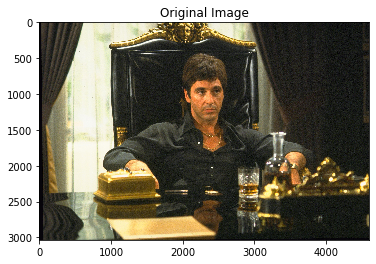

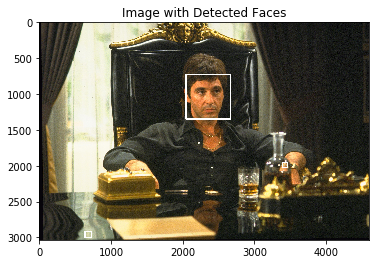

In [7]:
# show example image
sampleImage = cv2.cvtColor(cv2.imread('./images/detectionTask.jpg'), cv2.COLOR_BGR2RGB)   # This could be changed ot anything else
plt.imshow(sampleImage)
plt.title("Original Image")

# Use cv2 to identify boxes
fDetect = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(sampleImage, cv2.COLOR_RGB2GRAY)
t1 = time.time()
boxes = fDetect.detectMultiScale(gray, 1.3, 5)
print("Detection time: {}".format(time.time()-t1))
for (x,y,w,h) in boxes:
    # process all bounding boxes
    recImg = cv2.rectangle(sampleImage, (x,y), (x+w,y+h), color=(255,255,255,100), thickness=15)
plt.figure()
plt.imshow(recImg)
plt.title("Image with Detected Faces")

##### Analysis
Perhaps the first thing to notice is that this detection is still quite slow despite having the optimized classification pipeline! As it turns out, having to scan such large images is an intensive task as it requires the processing of significantly more sliding windows.

Could you think of a reason why the Haar Cascade detector might not be the proper face detector to use?

### YOLO (You Only Look Once) Detection (Deep Detection)

Much of YOLO's origin comes from the original problem that it was trying to tackle: improving the rate at which the R-CNN detector functions. Given that the R in R-CNN stood for regional, it made sense that this network simply suggested regions for which the item to be detected could be situated and then passed these regions to a CNN which classified the result as relevant or not. YOLO's breakthrough came about at the time during which this region proposal was framed as a deep learning problem (where the later half of the network would work to improve these initial estimates). YOLO simply decided to frame the problem in terms of this deep regional proposal network (RPN) performing a classification at the same time.

$$$$

#### R-CNN Detector
In this section, we will take brief look at R-CNN, which is a network commonly used for detection tasks (and is the basis of the YOLO network). If you looked carefully at the first CNN problem, you will have noticed that we had the ability to choose what we wanted to predict and how the loss function would be calculated. As it turns out, we could potentially convert a CNN classification task into a single object detection task by simply having a small output matrix that outputs some of the properties of the bounding box: $$\left(x,y,w,h,P(y=1|x),...,P(y=n|x)\right)$$ 

As it turns out, however, there are actually many cases where there are more than several faces in the original image. Because of this, we must have a network that is able generate an arbitrary number of bounding boxes for any given image. The problem here, however, is that there is basically no way to generate an arbitrary number of bounding boxes using basic deep networks. To get around this problem, we do the next best thing: instead of guessing where the bounding boxes are, we place anchor points that define a portion of the image and predict on all of those suggested regions instead! Most applications actually use this method as opposed to generating an arbitrary length output as it is a problem that leads to an easier deep network formulation. One such network that performs this task for varying feature map ratios is known as a regional proposal network (RPN). Since computing a convolution is naturally faster than performing a sliding window accross many downsized versions of an image, the hope is that the network should predict regions much more quickly than the Haar Cascade implementation.

![anchors](./images/frcnn.png)

The network is actually a bit more involved than the above explanation says because we still have to deal with the issue of varying ratio box sizes but have these get mapped to the same dimensional output proposal map (this is done via RoI pooling), deal with formatting a proper output for the initial RPN (in order to automatically throw out the background), and define a loss function over which to train, but the above basically captures the essence of what the network does.

$$$$

#### YOLO Detector
Recall above that the network first predicted some general boundaries for the bounding box using the RPN and then adjusted these boxes and classified the object soon after in the proceeding parts of the network. To most, it really doesn't make sense why the task of predicting the bounding boxes twice is done. After all, if a network can be used to predict the corrections for the box, why not just predict the proper box along with the probabilities at the same time. As it turns out, this is exactly what YOLO does! The network is first trained on a set of images to determine the set of "anchors" for which the images are most likely to be at (much like the original RPN from R-CNN). After this, the network is then trained end-to-end to predict the chances that any of these boxes contain the image along.

The final step of this network is to apply some non-maximal suppression in order to remove the boxes that are irrelevant (background) and combine boxes with high IoU as this usually means that they are suggesting the same object.

![yolo](./images/yolo.png)

In this step, we will be using the YOLO network in order to detect a couple faces from some random images in our dataset. Note that the network has been trained, but the thresholds were lowered due to the fact that the anchors were not trained for this particular dataset (CelebA).

In [7]:
# This small part downloads the weights and places them in the appropriate location
import os
import requests
from tqdm import tqdm 

WEIGHT_PATH = '1xG_9voxTJQjTvnJ22bhvMc0ve3hdc-RT'
SAVE_PATH = './Utils/YoloV3/checkpoints/yolov3_train_10.tf.data-00001-of-00002'

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()

    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination, chunk_size=32 * 1024):
    total_size = int(response.headers.get('content-length', 0))
    with open(destination, "wb") as f:
        for chunk in tqdm(
                response.iter_content(chunk_size),
                total=total_size,
                unit='B',
                unit_scale=True,
                desc=destination):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

# Process the download
if os.path.exists(SAVE_PATH):
    os.remove(SAVE_PATH)

download_file_from_google_drive(WEIGHT_PATH, SAVE_PATH)

./Utils/YoloV3/checkpoints/yolov3_train_10.tf.data-00001-of-00002: 12.6kB [00:37, 334B/s]


In [1]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from Utils.YoloV3.models import YoloV3
from Utils.YoloV3.dataset import transform_images
from Utils.YoloV3.utils import draw_outputs
DEFAULT_YOLO_SIZE = 416

# Feel free to use whatever image you like. However, if the image is too large, then 
# pyplot will likely not display the bounding boxes properly!
testImage = './images/tough.jpg' # CHANGE THIS TO WHATEVER

In [2]:
# Sets GPU usage to minimum memory usage if necessary
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loads YOLO model along with weights
yolo = YoloV3(classes=1)
yolo.load_weights('./Utils/YoloV3/checkpoints/yolov3_train_10.tf').expect_partial()
class_names = ["Face"]

Detection time: 0.16309571266174316


Text(0.5, 1.0, 'After reshaping boxes...')

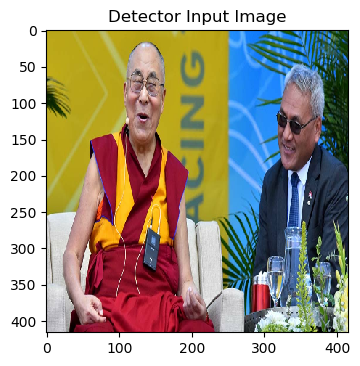

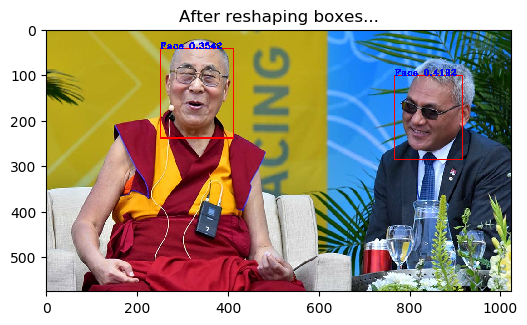

In [6]:
# Input image processing and displaying
img_raw = tf.image.decode_image(open(testImage, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, DEFAULT_YOLO_SIZE)

plt.figure(dpi=100)
plt.imshow(img.numpy().reshape(DEFAULT_YOLO_SIZE, DEFAULT_YOLO_SIZE, 3))
plt.title("Detector Input Image")

# duration for detection
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print('Detection time: {}'.format(t2 - t1))

# draws the boxes on the original image
out_img = draw_outputs(img_raw.numpy(), (boxes, scores, classes, nums), class_names)
plt.figure(dpi=100)
plt.imshow(out_img)
plt.title("After reshaping boxes...")

But now the real question is if it can classify the much larger image more quickly...

Detection time: 0.08224296569824219


Text(0.5, 1.0, 'Test Image')

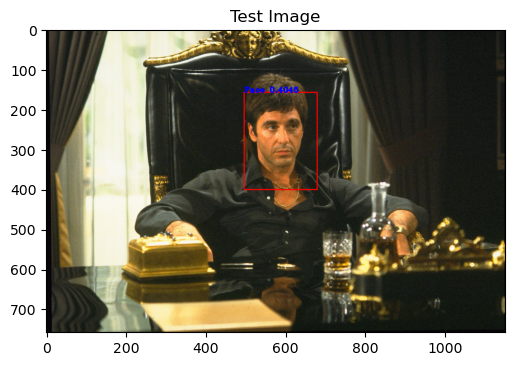

In [4]:
# loads the image
import cv2
testImage = './images/detectionTask.jpg'
img_raw = tf.image.decode_image(open(testImage, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, DEFAULT_YOLO_SIZE)

# duration for detection
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print('Detection time: {}'.format(t2 - t1))

# Here we resize the image before generating the bounding boxes as it is too large
resizedImg = cv2.resize(img_raw.numpy(), (0,0), fx=0.25, fy=0.25)
out_img = draw_outputs(resizedImg, (boxes, scores, classes, nums), class_names)
plt.figure(dpi=100)
plt.imshow(out_img)
plt.title("Test Image")

And it absolutely does! Notice that the rate at which the detection was done was exactly the same as that of the test image above. The reason for this is because the image is resized to a different ratio in order to accomodate the network. Of course, if the aspect ratio is taken to the extreme, then there will likely be some issues with some of the detector results. From here on out, we will be dealing with the aligned and cropped versions of the CelebA dataset (which can be found in the CelebA directory).
$$$$
At this point, the only steps left would be to run all of our images through the detectors and isolate the boxes that define where the face is located. There is technically a bounding box ratio that should be enforced, but it's often easier to take the larger value between the width and height and just assume the box is square.

##### Note: Please restart the kernel after this section as it may cause issues when executing the next part of the assignment.

## Face / Structural Alignment

As said before, this part will not be covered in depth because the math behind the process is a bit more involved than the rest of this project (it deals with the affine multiple view geometry in order to align a 3D skeleton or an affine transformation that aligns a set of facial landmarks). Unfortunately, getting a good understanding of how exactly that algorithm works would require more time in order to explain the entire background of CV (computer visiion) via epipolar geometry (epipolar rectification) and generate the motivating equations governing the affine transformation that does the rectification once solved. Note that often times just generating the facial landmarks is the more challenging part of the problem. After all, with particular views, we may not be able to see all facial features!
$$$$
If you would like to know more about how this works, feel free to consult this [page](http://vision.stanford.edu/teaching/cs231a_autumn1112/lecture/lecture9_epipolar_geometry_cs231a.pdf) (slides 45-57).
$$$$
As for the deep alignment, I suggest taking a look at [this](https://towardsdatascience.com/face-allignment-deep-multi-task-learning-203f46a22106) Medium article in conjunction with above for a more common implementation scheme. There's also [this](https://arxiv.org/pdf/1706.01789.pdf) paper on an attempt to create an end-to-end network for this task.

## Face Feature Extraction + Classification
For this section, we will be using a CNN in order to perform a feature extraction and classification. Due to the constraints of the loss function we will choose (cross-entropy), we will only be able to ascertain which class the current example most likely corresponds to. In this type of problem, the network is actually limited by the softmax as it doesn't allow for a more explicit output that shows how similar one face is to another. This will be covered more later on in this assignment. Note that we will be using Keras in order to create the network, much like in the previous example. Feel free to consult [this page]() for the CNN API as it is quite a bit to cover here. All of these layers should have already been covered by the initial lecture on the theory side of things.
$$$$
We will be using the VGG16 network as the base feature extractor in this classification problem. I have already pre-trained the network on some face detection class, so the features generated should be applicable to the new problem. The only thing that should be trained from scratch will be the dense portion of the classifier.


##### Note: If your computer is unable to properly train this network due to computational issues (usually this is a result of time to train), then feel free to just use the imagenet network without training. This part is mostly here to give another example of an end-to-end training for a particular dataset should you need it.

##### Dataset Creation
Here we use the ImageDataGenerator class Keras provides to automatically generate the dataset for us. All that we need to do beforehand is separate our dataset into directories that contain each class. Since the ImageDataGenerator can automatically provide the validation set for us as well, there is no need to create an explicit validation directory. However, in our use case we will not be dealing with a validation set as we are using an extremely small sample of the original dataset.

In [1]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 8 # you might need to adjust this depending on available memory

# Note that this class has a bunch of other options for online data augmentation!
# That will not be used in this example, however; we are not training from scratch...
datGenCreator = ImageDataGenerator(preprocessing_function = preprocess_input)
trainGen = datGenCreator.flow_from_directory('./CelebA/datasets/training', batch_size=BATCH_SIZE)
testGen = datGenCreator.flow_from_directory('./CelebA/datasets/testing', batch_size=BATCH_SIZE, shuffle=False)

Found 254 images belonging to 10 classes.
Found 77 images belonging to 10 classes.


In [2]:
# Note that this maps particular directories to integer value
# classes. This is required for the deep formulation of a
# classification problem
trainGen.class_indices

{'1757': 0,
 '2820': 1,
 '3227': 2,
 '3699': 3,
 '3745': 4,
 '3782': 5,
 '6568': 6,
 '8968': 7,
 '9152': 8,
 '9256': 9}

##### Model Creation & Training (Softmax Type)
Now we train a __softmax__ type network for this task. What I mean by this is that the task being performed is a classification task that immediately tries to estimate the probability of an input sample pertaining to some particular class. There is no restriction on the type of function the neural network can estimate so long as it can guarantee that the desired class has the highest probability of occurring if it is the sample's class. Note that this will be important in the next section where we train another network from scratch using __triplet loss__, which does not immediately solve the problem but can be used to do so...
$$$$
To be precise, we are training the network to learn a set of probabilities, $P(Y=y_i|X=x_i)$, that is defined as the probability of some sample $x_i$ coming from class $y_i$. However, the network only approximates this density distribution, so there should be some distinction made when formally describing the problem: $$P(Y|X=x_i)\approx f(x_i;\mathbf{W}) = \text{softmax}(\text{logits}(x_i;\mathbf{W}))$$

where logits is simply a set of un-normalized probabilities (which the softmax converts into probabilities).

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16

# Sets up GPU again
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# define VGG model with dense layers for use with two losses
# lossType can be 'crossentropy' or 'triplet'
def model(listDense, lossType='crossentropy', imgSize=(178,218,3), frozen=True):
    inTensor = keras.Input(shape=imgSize)
    netIn = VGG16(input_tensor=inTensor, weights='imagenet', include_top=False)
    
    # prevent further training of VGG layers
    if frozen:
        for layer in netIn.layers:
            layer.trainable = False
    
    # Flatten output and apply dense layers
    y = netIn.output
    y = keras.layers.GlobalAveragePooling2D()(y)
    y = keras.layers.Dropout(0.5)(y)
    for ind, denseNum in enumerate(listDense):
        y = keras.layers.Dense(denseNum, activation=None)(y)
        if ind == len(listDense)-1:
            break
        y = keras.layers.Activation('relu', name='ReLu_{}'.format(ind))(y)
        y = keras.layers.Dropout(0.5)(y)
    
    # Sets up final layer for the triplet loss visualization
    if lossType == 'triplet':
        y = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='L2Norm')(y)
    elif lossType == 'crossentropy':
        y = keras.layers.Activation('softmax', name='Softmax')(y)
        
    return keras.Model(inputs=netIn.input, outputs=y)

In [4]:
# Number of people to identify
NUM_CLASSES = 10

# Model declaration (Model Type 1)
mod = model([1024, 512, NUM_CLASSES], lossType='crossentropy')
opt = keras.optimizers.Adam(lr=0.0005)
mod.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 178, 218, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 178, 218, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 178, 218, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 109, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 89, 109, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 89, 109, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 54, 128)       0     

In [5]:
# The model can now be trained! This should take a moment on most CPUs, but be very quick on a GPU.
# Note: Change number of epochs depending on the time it takes to train the network
hist = mod.fit_generator(trainGen, epochs=100, validation_data=testGen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
32/32 [==============================] - 2s 61ms/step - loss: 7.3057 - acc: 0.1063 - val_loss: 2.0584 - val_acc: 0.3247
Epoch 2/100
32/32 [==============================] - 1s 42ms/step - loss: 5.0771 - acc: 0.1535 - val_loss: 1.7591 - val_acc: 0.2857
Epoch 3/100
32/32 [==============================] - 1s 41ms/step - loss: 3.8487 - acc: 0.2638 - val_loss: 1.6163 - val_acc: 0.3636
Epoch 4/100
32/32 [==============================] - 1s 41ms/step - loss: 3.2089 - acc: 0.2756 - val_loss: 1.6418 - val_acc: 0.4156
Epoch 5/100
32/32 [==============================] - 1s 41ms/step - loss: 2.8285 - acc: 0.2913 - val_loss: 1.4693 - val_acc: 0.4805
Epoch 6/100
32/32 [==============================] - 1s 42ms/step - loss: 2.4285 - acc: 0.3189 - val_loss: 1.3873 - val_acc: 0.5455
Epoch 7/100
32/32 [==============================] - 1s 42ms/step - loss: 2.3150 - acc: 0.3425 - val_loss: 1.3884 - val_acc: 0.5325


KeyboardInterrupt: 

As seen above, the model is clearly training. However, if you are wondering what the peak accuracy will be, then taking a look at the following two plots from a training session I ran on my own should give an idea of the convergence.

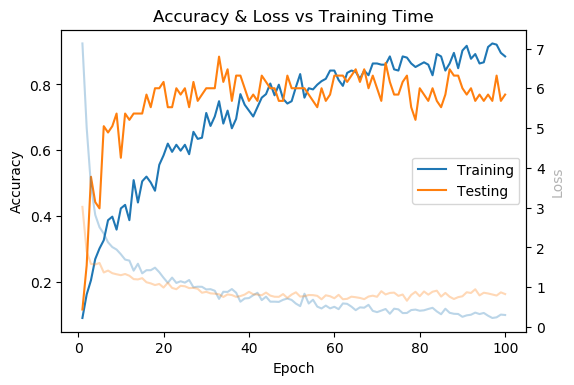

In [63]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(dpi=100)
ax2 = ax1.twinx()
ax1.plot(range(1,101), hist.history['acc'], label='Training')
ax1.plot(range(1,101), hist.history['val_acc'], label='Testing')
ax2.plot(range(1,101), hist.history['loss'], alpha=0.3, label='Training')
ax2.plot(range(1,101), hist.history['val_loss'], alpha=0.3, label='Testing')

ax1.legend(loc=5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss', alpha=0.3)
ax1.set_title("Accuracy & Loss vs Training Time")
plt.show()

Perhaps the first thing to notice from thsi plot is that there is some form of overfitting that is beginning to occur. We can see that the testing accuracy seems to plateau at about an accuracy of $0.8$ and loss of $0.9$, but the network continues to train on the training dataset and thus reduce the loss and increase the accuracy for that set. This is commonly known as overfitting. Normally if we extend this graph farther to the right, we will eventually see the testing accuracy decrease as a result of the network attempting to "memorize" the training data samples. 
$$$$
Of course, this "memorization" was slightly reduced by the dropout layer being present along with soem other forms of regularization that are intrinsic to the network. We will not, however, discuss why particular forms of regularization / normalization work so well for neural networks. That discussion will be left to your future classes.

##### Model Creation & Training (Triplet Loss Type)

![triplet learning](./images/tripletLearning.png)

The general process of triplet loss could be seen in the image above and explained more generally using the Obama pic in the start of the notebook. The network learns some embedding that maximizes the minimizes the triplet loss. The triplet loss formula is as follows:

$$\mathcal{L} = \sum_{i=1}^N \left[\left\|f^a_i-f^p_i\right\|^2 - \left\|f^a_i-f^n_i\right\|^2 + \alpha\right]_+$$

where

$$\left[-\right]_+ \equiv \max\left(-,0\right)$$

The main thing to take away is that optimization would attempt to minimize the first two terms. The first term, $\left\|f^a_i-f^p_i\right\|^2$, is the distance from an anchor to a __positive__ point (AKA, an image we know is from the correct class). In other words, we want to ensure that our anchor (or current image) is as close as possible to some other point in the same class in order to minimize this term. The second term, $-\left\|f^a_i-f^n_i\right\|^2$, is the distance from an anchor to a __negative__ point. In order to minimize this term, we must _maximize_ this value as it is a negative value. This means that we will be attempting to make sure thatour anchor is as far away as possible to any given point from some other class. The $\alpha$ parameter is a slack variable used to control the margins we would like between the positive and negative samples (or at least the optimal margin to stop training at once reached).
$$$$
As you may be able to tell from the formulation above, one thing to pay attention to is that the network is __trained using (anchor, positive, negative) triplets instead of the usual (sample, class) tuples__. This is one of the defining features of the triplet loss function. The last thing to take note of is that this formulation functions very similar to an SVM network. The only samples that affect the overall network are those that lie within the margins defined by $f_i^1$, $f^p_i$, and $\alpha$ (thus, the negative samples are hard or semi-hard samples to separate).
$$$$
One thing to realize is that by using this triplet loss formulation for the network, it acts more like a __clustering__ network than a classification network. In other words, the embedding space along with whatever properties it exhibits is the end result of this network. In order to detect who the person in question is, there will need to be some distance measuring and/or thresholding in order to filter out out-of-dataset samples.

In [6]:
# Recreates the data generator but with extra normalization
datGenCreator = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = False, preprocessing_function=lambda image:image/255.)

# takes a sample of data and fits the normalization procs on them
trainGen = datGenCreator.flow_from_directory('./CelebA/datasets/training', batch_size=279, class_mode='binary')
datGenCreator.fit(trainGen.next()[0])

# Then proceed to create the actual datasets
trainGen = datGenCreator.flow_from_directory('./CelebA/datasets/training', batch_size=BATCH_SIZE, class_mode='binary')

Found 254 images belonging to 10 classes.


/opt/anaconda/envs/tf_new/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Found 254 images belonging to 10 classes.


In [9]:
# extra import
import tensorflow_addons as tfa

# Model declaration (Model Type 1)
mod = model([256], lossType='triplet')
opt = keras.optimizers.Adam(lr=0.001)
mod.compile(optimizer=opt, loss=tfa.losses.TripletSemiHardLoss())
mod.summary()

ImportError: cannot import name 'keras_tensor' from 'tensorflow.python.keras.engine' (/opt/anaconda/envs/tf_new/lib/python3.8/site-packages/tensorflow/python/keras/engine/__init__.py)

In [212]:
# This should train slightly faster but also take much longer to 
# calculate the proper embeddings due to the complexity of the problem
histTriplet = mod.fit_generator(trainGen, epochs=500)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 35 steps
Epoch 1/500
35/35 [==============================] - 2s 51ms/step - loss: 0.8636
Epoch 2/500
35/35 [==============================] - 1s 32ms/step - loss: 0.8149
Epoch 3/500
35/35 [==============================] - 1s 32ms/step - loss: 0.7570
Epoch 4/500
35/35 [==============================] - 1s 33ms/step - loss: 0.8089
Epoch 5/500
35/35 [==============================] - 1s 32ms/step - loss: 0.7530
Epoch 6/500
35/35 [==============================] - 1s 33ms/step - loss: 0.7864
Epoch 7/500
35/35 [==============================] - 1s 33ms/step - loss: 0.7644
Epoch 8/500
35/35 [==============================] - 1s 33ms/step - loss: 0.7174
Epoch 9/500
35/35 [==============================] - 1s 33ms/step - loss: 0.7462
Epoch 10/500
35/35 [==============================] - 1s 32ms/step - loss: 0.7157
Epoch 11/500
35/35 [==============================] - 1s 33ms/step - loss: 0.7206
Epoch 12/500
35/35 [==============================] - 1s 33ms/step - loss: 0.7165
Epoch 

35/35 [==============================] - 1s 33ms/step - loss: 0.3496
Epoch 199/500
35/35 [==============================] - 1s 33ms/step - loss: 0.4196
Epoch 200/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3465
Epoch 201/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3352
Epoch 202/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3661
Epoch 203/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3999
Epoch 204/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3382
Epoch 205/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3518
Epoch 206/500
35/35 [==============================] - 1s 33ms/step - loss: 0.4016
Epoch 207/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3172
Epoch 208/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3586
Epoch 209/500
35/35 [==============================] - 1s 33ms/step - loss: 0.3077
Epoch 210/500
35/3

35/35 [==============================] - 1s 31ms/step - loss: 0.2230
Epoch 394/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2797
Epoch 395/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2539: 0s -
Epoch 396/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2054
Epoch 397/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2398
Epoch 398/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2688
Epoch 399/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2297
Epoch 400/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2975
Epoch 401/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2353
Epoch 402/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2267
Epoch 403/500
35/35 [==============================] - 1s 31ms/step - loss: 0.3041
Epoch 404/500
35/35 [==============================] - 1s 31ms/step - loss: 0.2860: 0s - loss:


Text(0, 0.5, 'Triplet Loss')

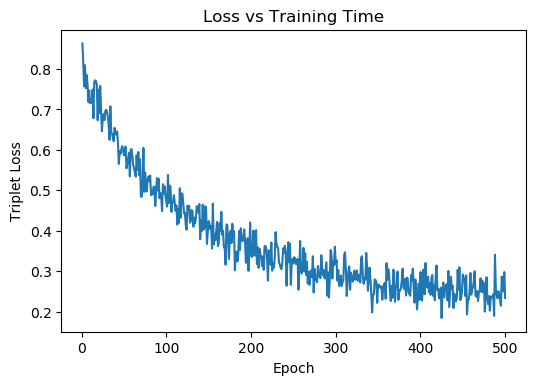

In [216]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
plt.plot(range(1,501), histTriplet.history['loss'])
plt.title("Loss vs Training Time")
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")

But just having these random embeddings isn't exactly solving the problem... In order to make sure that the problem is being properly modeled, we can project our test dataset to the embedding space and expect the samples to lie closest to the sample that they correspond to. This can be most easily verified using a UMAP projection. Luckily, tensorflow gives us the ability to visualize these types of embeddings using their online service which can be found [here](https://projector.tensorflow.org/).

In [ ]:
import io

iters = int((279+(BATCH_SIZE-1))/BATCH_SIZE)
results = mod.predict(trainGen)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for iterNum in range(iters):
    labels = trainGen.next()[1].tolist()
    [out_m.write(str(int(x)) + "\n") for x in labels]
out_m.close()

For our convenience, I'll also present a 2D representation of the plot on the bottom here. Make sure you don't run this as it will mess up the resultant plot if you do so. [You will also likely not have the packages required to run this excerpt.]

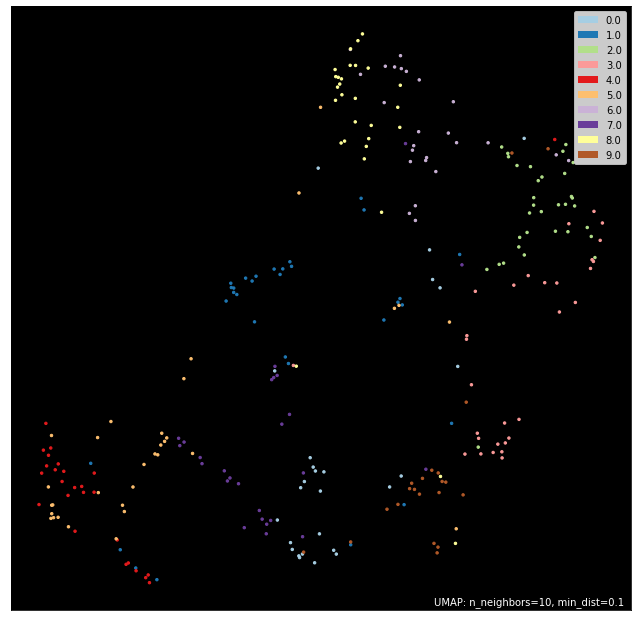

In [36]:
import umap
import umap.plot
import numpy as np

resVecs = np.loadtxt("vecs.tsv", delimiter='\t')
mapper = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean').fit(resVecs)
umap.plot.points(mapper, labels=np.loadtxt("meta.tsv"), color_key_cmap='Paired', background='black')

First of all, note that the separation isn't that great between classes. However, given that we were only given a handful of images for each class that were of mostly subpar quality, this is a fairly reasonable view of the distribution. It also allows us to think about which classes the network thinks are "similar" by checking the distribution of these images in this projection. Note that in most state-of-the-art face recognition tasks (those that operate on perhaps tens of thousands of users), there is actually an intermediate clustering step. Perhaps thinking about why we would like to emphasize this distancing between faces is a good topic to investigate. 
$$$$
Why exactly is it that we prefer to operate on this embedded space as opposed to working with optimizing a probability directly?